# Step 1. 실험환경 Set-up

In [4]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [5]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 30

print(ROOT_PATH)

/aiffel/aiffel


# Step 2. 데이터 준비하기

In [6]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [7]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))
# 이제 train은 4185개, test는 624개, val은 1047개가 되었습니다. test_size를 수정하면 개수는 달라질 수 있습니다.

4185
1047


In [8]:
# 미니 배치로 tf.data 인스턴스를 만들기.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
# Train 데이터셋, validation 데이터셋 개수 확인해보기.
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
# train 데이터 셋과 validation 데이터 셋을 만듭니다. 
# num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있습니다.
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지 및 라벨을 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
# test 데이터셋도 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image) # 랜덤하게 좌우를 반전합니다. 
    return image, label

def prepare_for_training(ds,shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다. 
    ds = ds.map(
            augment, 
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size = AUTOTUNE)
    
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# step 3. 데이터 시각화

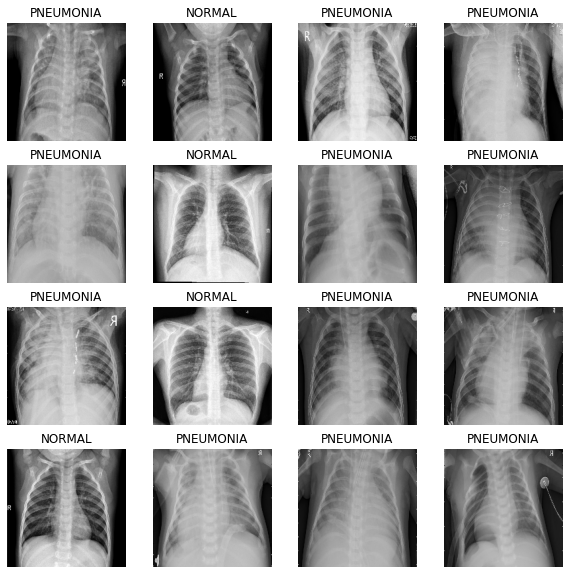

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n].numpy()) # .astype('uint8')
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)

# Step 4. ResNet-18 구현
ResNet은 Residual block을 먼저 구성해야 합니다. ResNet에서의 weight layer는

1. 3x3 CNN
2. BatchNormalization
3. 활성화 함수 ReLU
로 구성되어 있습니다.
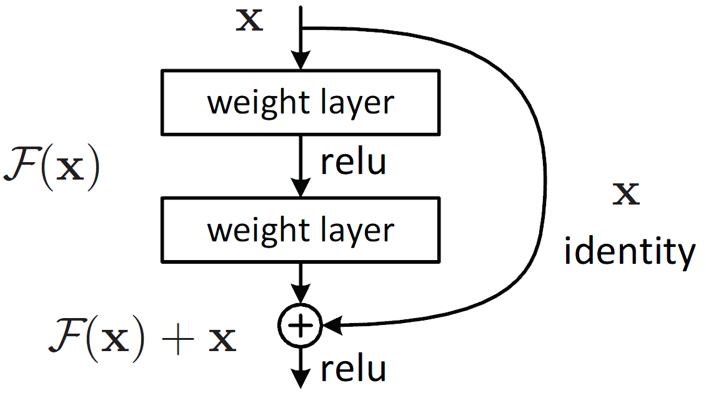

In [16]:
# Residual block을 만듭니다.
def conv_residual_block(x, filters, strides=1):
    shortcut = x
    
    x = tf.keras.layers.Conv2D(filters, 3, strides=strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(filters, 3, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x   

## 그림을 보고 ResNet을 구현
 (참고사항 : 해당 table은 ImageNet Challenge를 가정했기 때문에 filter개수는 튜닝하면서 바꿔주세요!)
 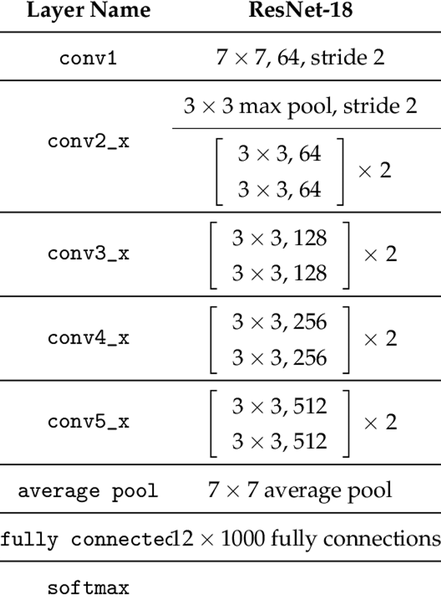

In [17]:
def build_resnet18_model():
    input_layer = tf.keras.layers.Input(shape=(180, 180, 3))
    
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.MaxPool2D(3, strides=2, padding='same')(x)
    x = conv_residual_block(x, 64)
    x = conv_residual_block(x, 64)
    
    x = conv_residual_block(x, 128, strides=2)
    x = conv_residual_block(x, 128)
    
    x = conv_residual_block(x, 256, strides=2)
    x = conv_residual_block(x, 256)
    
    x = conv_residual_block(x, 512, strides=2)
    x = conv_residual_block(x, 512)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x) # 크기 지정할 필요없이 항상 1x1의 크기로 변환함. 7x7 -> 1x1 
    
    x = tf.keras.layers.Dense(512, activation='relu')(x)  
    x = tf.keras.layers.Dropout(0.3)(x)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x) # '정상'과 '폐렴' 두 가지로 분류하는 이진분류문제로 softmax보다는 sigmoid사용하는 것이 적합함.
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model
model = build_resnet18_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 90, 90, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 90, 90, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Step 5. 데이터 imbalance 처리
실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었다. 
- 만약 이러한 처리를 생략한다면 어떻게 될까요? 
- 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

In [18]:
# 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있다. 
# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [19]:
# 생략

In [20]:
# imbalance 처리하기.
# weight_for_0은 'Normal' 이미지에 사용할 weight를,
# weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅.
# 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정.

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


# Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다. 

In [28]:
with tf.device('/GPU:0'):
    model = build_resnet18_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
# model.fit()하기.
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#         class_weight=class_weight # imbalance 처리 부분에서 정의.
    )

Epoch 1/30
261/261 [==============================] - 83s 203ms/step - loss: 0.2825 - accuracy: 0.8927 - precision: 0.9255 - recall: 0.9308 - val_loss: 1.9044 - val_accuracy: 0.7529 - val_precision: 0.7480 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - 51s 196ms/step - loss: 0.1659 - accuracy: 0.9399 - precision: 0.9563 - recall: 0.9633 - val_loss: 0.4332 - val_accuracy: 0.8337 - val_precision: 0.8152 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - 51s 198ms/step - loss: 0.1490 - accuracy: 0.9423 - precision: 0.9581 - recall: 0.9646 - val_loss: 0.1850 - val_accuracy: 0.9250 - val_precision: 0.9082 - val_recall: 0.9987
Epoch 4/30
261/261 [==============================] - 51s 198ms/step - loss: 0.1343 - accuracy: 0.9523 - precision: 0.9672 - recall: 0.9688 - val_loss: 0.1772 - val_accuracy: 0.9298 - val_precision: 0.9280 - val_recall: 0.9803
Epoch 5/30
261/261 [==============================] - 52s 199ms/step - loss: 0.1208 - accura

In [21]:
with tf.device('/GPU:0'):
    model_imbalanced = build_resnet18_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_imbalanced.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
# model.fit()하기.
with tf.device('/GPU:0'):
    history = model_imbalanced.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#         class_weight=class_weight # imbalance 처리 부분에서 정의.
    )

Epoch 1/30
261/261 [==============================] - 65s 198ms/step - loss: 0.2847 - accuracy: 0.8908 - precision: 0.9242 - recall: 0.9295 - val_loss: 11.3156 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - 51s 194ms/step - loss: 0.1735 - accuracy: 0.9341 - precision: 0.9554 - recall: 0.9563 - val_loss: 1.7934 - val_accuracy: 0.4298 - val_precision: 1.0000 - val_recall: 0.2208
Epoch 3/30
261/261 [==============================] - 51s 195ms/step - loss: 0.1332 - accuracy: 0.9452 - precision: 0.9615 - recall: 0.9649 - val_loss: 0.2689 - val_accuracy: 0.9413 - val_precision: 0.9366 - val_recall: 0.9869
Epoch 4/30
261/261 [==============================] - 51s 196ms/step - loss: 0.1266 - accuracy: 0.9540 - precision: 0.9685 - recall: 0.9698 - val_loss: 4.9417 - val_accuracy: 0.2952 - val_precision: 1.0000 - val_recall: 0.0368
Epoch 5/30
261/261 [==============================] - 51s 197ms/step - loss: 0.1149 - accur

# Step 7. 결과 확인과 시각화

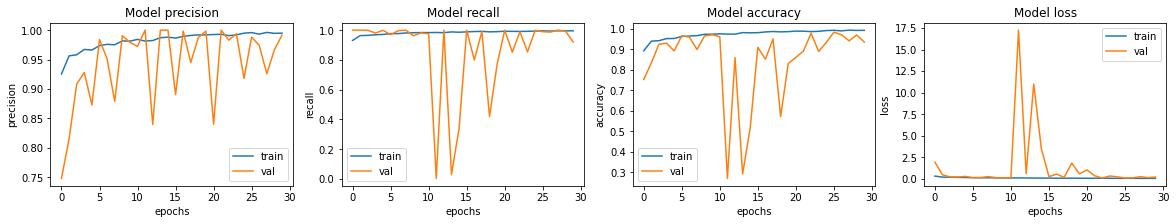

In [24]:
# imbalance 처리 생략한 결과 시각화
fig, ax = plt.subplots(1,4,figsize=(20,3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train','val'])

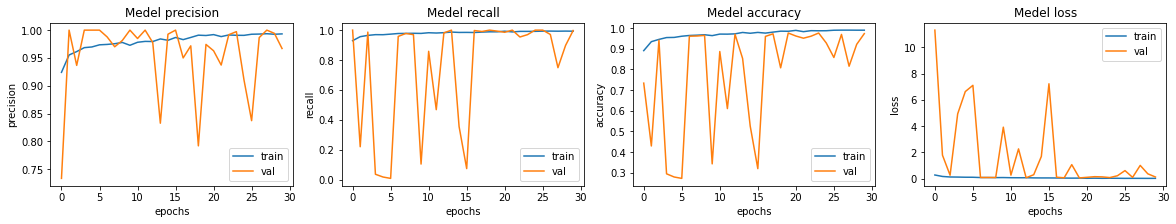

In [24]:
# imbalance 처리 진행한 결과 시각화
fig, ax = plt.subplots(1,4,figsize=(20,3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Medel {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train','val'])

1. imbalance 처리 생략한 결과
- 26번 epoch 모델이 최적 모델임. -> 더 학습하면 더 좋은 성능 나올 수도 있을 것 같음. 그러나 크게 향상은 어려움. 비효율적.
- val metrics의 기복이 심함. -> learningrate를 설정해서 0.0001로 낮춰봐야 아웃라이어에 덜 예민하게 반영할 것이다.
2. imbalance 처리 진행한 결과
- 20번 epoch 모델이 초적 모델임.
- val metrics의 기복이 심함. -> learningrate를 설정해서 0.0001로 낮춰봐야 아웃라이어에 덜 예민하게 반영할 것이다.

### 아직 개선해볼만 부분이 있어 보여 여러가지 시도를 해볼 수 있다. 